In [1]:
from darts.models import TFTModel
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from darts.utils.likelihood_models import QuantileRegression
import utils
from darts import TimeSeries
import numpy as np
import pandas as pd
from darts.metrics import rmse
from darts.models import NaiveSeasonal
from darts.metrics import rmse, mape, r2_score
from darts.dataprocessing import Pipeline
from darts.dataprocessing.transformers import (
    Scaler,
    MissingValuesFiller,
    Mapper,
    InvertibleMapper,
    Diff
)
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import torch

/opt/conda/lib/python3.11/site-packages/statsforecast/utils.py:231: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  "ds": pd.date_range(start="1949-01-01", periods=len(AirPassengers), freq="M"),


In [2]:
df = utils.load_data()

# Create a TimeSeries object
ts = TimeSeries.from_dataframe(df, value_cols=['US_TB_YIELD_10YRS']) #.add_holidays("US")

# Create covariates
covariates = df.drop(columns=['US_TB_YIELD_10YRS'])
covariates = TimeSeries.from_dataframe(covariates)

In [14]:
log_transformer = InvertibleMapper(
    fn=np.log1p, inverse_fn=np.expm1, name="log1p"
)
scaler = Scaler(StandardScaler())
filler = MissingValuesFiller()
differentiator = Diff(dropna=True)
pipeline = Pipeline([filler, log_transformer, scaler, differentiator])
covariates_pipeline = Pipeline([filler, log_transformer, scaler, differentiator])




covariates_scaled = covariates_pipeline.fit_transform(covariates)
ts_scaled = pipeline.fit_transform(ts)
train_ts_scaled, val_ts_scaled = ts_scaled.split_after(pd.Timestamp("2016-01-01"))
val_ts = ts.drop_before(pd.Timestamp("2016-01-01"))
train_covariates_scaled, val_covariates_scaled = covariates_scaled.split_after(pd.Timestamp("2016-01-01"))

<Axes: xlabel='DATE'>

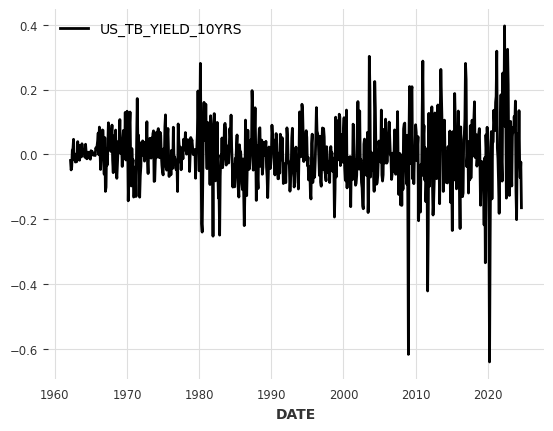

In [4]:
ts_scaled.plot()

In [5]:
input_chunk_length = 18
forecast_horizon = 12
model = TFTModel(
    input_chunk_length=input_chunk_length,
    output_chunk_length=forecast_horizon,
    hidden_size=80,
    lstm_layers=1,
    num_attention_heads=2,
    dropout=0.1,
    batch_size=32,
    n_epochs=30, #300,
    add_relative_index=True,
    add_encoders={'cyclic': {'future': ['month']}},
    # likelihood=QuantileRegression(),  # QuantileRegression is set per default
    # loss_fn=torch.nn.MSELoss(),
    optimizer_kwargs={"lr": 1e-5},
    random_state=42,
)

model.fit(
        series=train_ts_scaled, 
        past_covariates=train_covariates_scaled,
        val_series=val_ts_scaled,
        val_past_covariates = val_covariates_scaled, 
        verbose=True
    )


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

   | Name                              | Type                             | Params | Mode 
------------------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0      | train
1  | val_metrics                       | MetricCollection                 | 0      | train
2  | input_embeddings                  | _MultiEmbedding                  | 0      | train
3  | static_covariates_vsn             | _VariableSelectionNetwork        | 0      | train
4  | encoder_vsn                       | _VariableSelectionNetwork        | 17.4 K | train
5  | decoder_vsn                       | _VariableSelectionNetwork        | 6.4 K  | train
6  | static_context_grn                | _GatedResidualNetwork            | 26.1 K | train
7  | static_context_hidden_encoder_grn | _GatedResidualNetwork 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=30` reached.


TFTModel(output_chunk_shift=0, hidden_size=80, lstm_layers=1, num_attention_heads=2, full_attention=False, feed_forward=GatedResidualNetwork, dropout=0.1, hidden_continuous_size=8, categorical_embedding_sizes=None, add_relative_index=True, loss_fn=None, likelihood=None, norm_type=LayerNorm, use_static_covariates=True, input_chunk_length=18, output_chunk_length=12, batch_size=32, n_epochs=30, add_encoders={'cyclic': {'future': ['month']}}, optimizer_kwargs={'lr': 1e-05}, random_state=42)

In [13]:
# before starting, we define some constants
num_samples = 200

figsize = (9, 6)
lowest_q, low_q, high_q, highest_q = 0.05, 0.1, 0.9, 0.95
label_q_outer = f"{int(lowest_q * 100)}-{int(highest_q * 100)}th percentiles"
label_q_inner = f"{int(low_q * 100)}-{int(high_q * 100)}th percentiles"

In [7]:
fcast_scaled = model.historical_forecasts(
    series=ts_scaled,
    past_covariates=covariates_scaled,
    start = pd.Timestamp("2015-02-01"),
    forecast_horizon=forecast_horizon,
    verbose=True,
    retrain=False,
    num_samples=200,
    last_points_only=True
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

In [9]:
fcast = pipeline.inverse_transform(train_ts_scaled.append(fcast_scaled.mean()), partial=True)



model.backtest(series=ts, historical_forecasts=fcast, last_points_only=True)

5.704077672076755

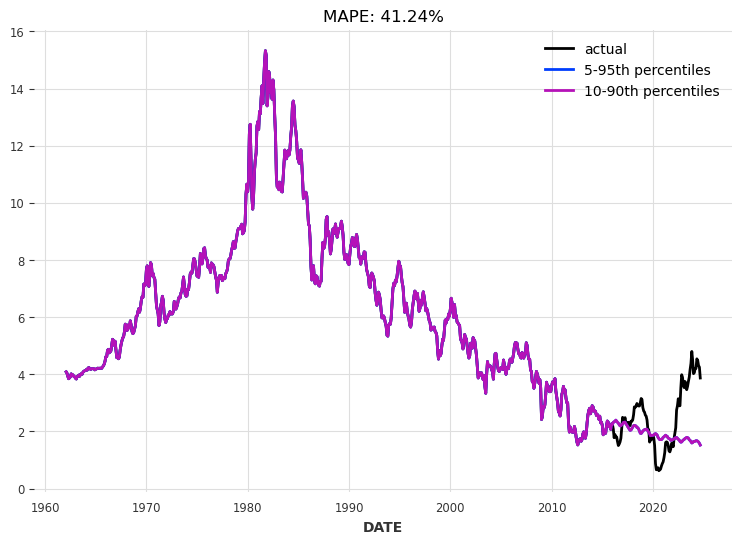

In [15]:
# plot actual series
plt.figure(figsize=figsize)
ts[: fcast.end_time()].plot(label="actual")

# plot prediction with quantile ranges
fcast.plot(
    low_quantile=lowest_q, high_quantile=highest_q, label=label_q_outer
)
fcast.plot(low_quantile=low_q, high_quantile=high_q, label=label_q_inner)

plt.title(f"MAPE: {mape(val_ts, fcast.mean()):.2f}%")
plt.legend()

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

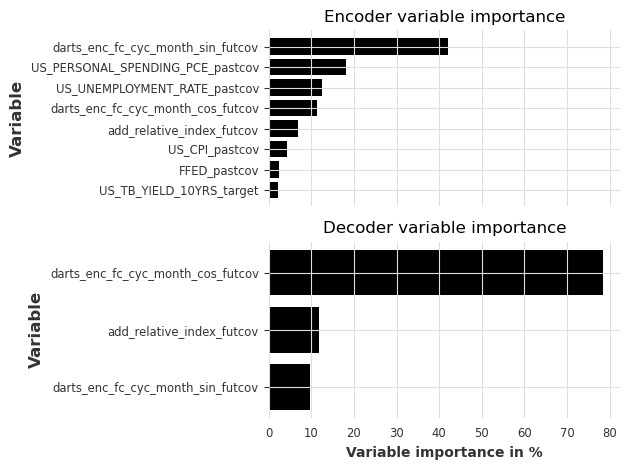

In [11]:
from darts.explainability import TFTExplainer


explainer = TFTExplainer(model)

explainability_result = explainer.explain()


explainer.plot_variable_selection(explainability_result)

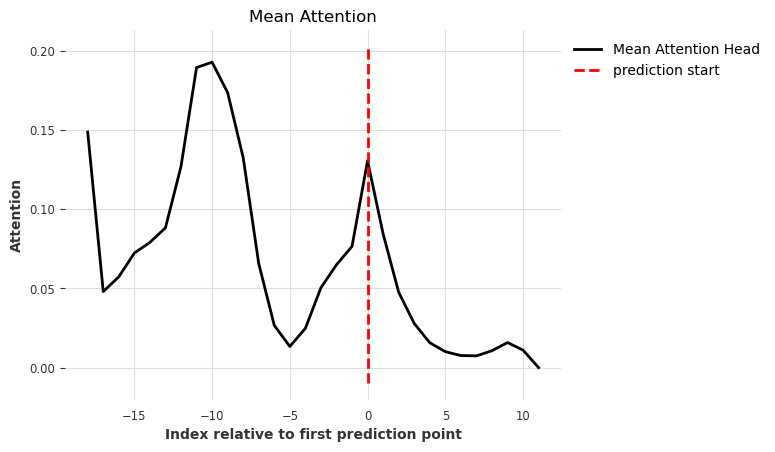

<Axes: title={'center': 'Mean Attention'}, xlabel='Index relative to first prediction point', ylabel='Attention'>

In [12]:
explainer.plot_attention(explainability_result, plot_type="time")